# Angular Reflectance Spectrum of a Planar Interface

We turn to a similar but slightly different example for which there exists an analytic solution via the [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations): computing the broadband reflectance spectrum of a planar air-dielectric interface for an incident planewave over a range of angles. Similar to the previous example, we will need to run two simulations: (1) an empty cell with air/vacuum ($n$=1) everywhere to obtain the incident flux, and (2) with the dielectric ($n$=3.5) interface to obtain the reflected flux. For each angle of the incident planewave, a separate simulation is necessary.

A 1d cell must be used since a higher-dimensional cell will introduce [artificial modes due to band folding](https://meep.readthedocs.io/en/latest/FAQ/#why-are-there-strange-peaks-in-my-reflectancetransmittance-spectrum-when-modeling-planar-or-periodic-structures). We will use a Gaussian source spanning visible wavelengths of 0.4 to 0.8 μm. Unlike a [continuous-wave](https://meep.readthedocs.io/en/latest/Python_User_Interface/#continuoussource) (CW) source, a pulsed source turns off. This enables a termination condition of when there are no fields remaining in the cell (due to absorption by the PMLs) via the [run function](https://meep.readthedocs.io/en/latest/Python_User_Interface/#run-functions) `stop_when_fields_decayed`, similar to the previous example.

Creating an oblique planewave source typically requires specifying two parameters: (1) for periodic structures, the Bloch-periodic wavevector $\vec{k}$ via [`k_point`](https://meep.readthedocs.io/en/latest/FAQ/#how-does-k_point-define-the-phase-relation-between-adjacent-unit-cells), and (2) the source amplitude function `amp_func` for setting the $e^{i\vec{k} \cdot \vec{r}}$ spatial dependence ($\vec{r}$ is the position vector). Since we have a 1d cell and the source is at a single point, it is not necessary to specify the source amplitude (see this [2d example](https://github.com/NanoComp/meep/blob/master/python/examples/pw-source.py) for how this is done). The magnitude of the Bloch-periodic wavevector is specified according to the dispersion relation formula for a planewave in homogeneous media with index $n$: $ω=c|\vec{k}|/n$. As the source in this example is incident from air, $|\vec{k}|$ is simply equal to the frequency $ω$ (the minimum frequency of the pulse which excludes the 2π factor). Note that a fixed wavevector only applies to a single frequency. Any broadband source is therefore incident at a specified angle for only a *single* frequency. This is described in more detail in Section 4.5 ("Efficient Frequency-Angle Coverage") in [Chapter 4](https://arxiv.org/abs/1301.5366) ("Electromagnetic Wave Source Conditions") of the book [Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology](https://www.amazon.com/Advances-FDTD-Computational-Electrodynamics-Nanotechnology/dp/1608071707).

In this example, the plane of incidence which contains $\vec{k}$ and the surface normal vector is $xz$. The source angle θ is defined in degrees in the counterclockwise (CCW) direction around the $y$ axis with 0 degrees along the +$z$ axis. In Meep, a 1d cell is defined along the $z$ direction. When $\vec{k}$ is not set, only the $E_x$ and $H_y$ field components are permitted. A non-zero $\vec{k}$ results in a 3d simulation where all field components are allowed and are complex (the fields are real, by default). A current source with $E_x$ polarization lies in the plane of incidence and corresponds to the convention of $\mathcal{P}$-polarization. In order to model the $\mathcal{S}$-polarization, we must use an $E_y$ source. This example involves just the $\mathcal{P}$-polarization.

In [1]:
import meep as mp
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

resolution = 50  # pixels/um

dpml = 1.0  # PML thickness
sz = 10 + 2 * dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

wvl_min = 0.4  # min wavelength
wvl_max = 0.8  # max wavelength
fmin = 1 / wvl_max  # min frequency
fmax = 1 / wvl_min  # max frequency
fcen = 0.5 * (fmin + fmax)  # center frequency
df = fmax - fmin  # frequency width
nfreq = 50  # number of frequency bins


def planar_reflectance(theta):
    # rotation angle (in degrees) of source: CCW around Y axis, 0 degrees along +Z axis
    theta_r = math.radians(theta)

    # plane of incidence is XZ; rotate counter clockwise (CCW) about y-axis
    k = mp.Vector3(z=fmin).rotate(mp.Vector3(y=1), theta_r)

    # if normal incidence, force number of dimensions to be 1
    if theta_r == 0:
        dimensions = 1
    else:
        dimensions = 3

    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ex,
            center=mp.Vector3(z=-0.5 * sz + dpml),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=k,
        dimensions=dimensions,
        resolution=resolution,
    )

    refl_fr = mp.FluxRegion(center=mp.Vector3(z=-0.25 * sz))
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )

    empty_flux = mp.get_fluxes(refl)
    empty_data = sim.get_flux_data(refl)

    sim.reset_meep()

    # add a block with n=3.5 for the air-dielectric interface
    geometry = [
        mp.Block(
            mp.Vector3(mp.inf, mp.inf, 0.5 * sz),
            center=mp.Vector3(z=0.25 * sz),
            material=mp.Medium(index=3.5),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=k,
        dimensions=dimensions,
        resolution=resolution,
    )

    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    sim.load_minus_flux_data(refl, empty_data)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )

    refl_flux = mp.get_fluxes(refl)
    freqs = mp.get_flux_freqs(refl)

    wvls = np.empty(nfreq)
    theta_out = np.empty(nfreq)
    R = np.empty(nfreq)
    for i in range(nfreq):
        wvls[i] = 1 / freqs[i]
        theta_out[i] = math.degrees(math.asin(k.x / freqs[i]))
        R[i] = -refl_flux[i] / empty_flux[i]
        print("refl:, {}, {}, {}, {}".format(k.x, wvls[i], theta_out[i], R[i]))

    return k.x * np.ones(nfreq), wvls, theta_out, R

The function `planar_reflectance` computes the reflectance at each frequency as well as the wavevector component $k_x$ and the corresponding angle for the ($k_x$, ω) pair. For those frequencies not equal to the minimum frequency of the source, this is *not* the same as the specified angle of the incident planewave, but rather sin<sup>-1</sup>(k<sub>x</sub>/ω).

The reflectance spectrum is generated over the angular range of 0$^\circ$ to 80$^\circ$ in increments of 5$^\circ$.

In [2]:
theta_in = np.arange(0, 85, 5)
wvl = np.empty(nfreq)
kxs = np.empty((nfreq, theta_in.size))
thetas = np.empty((nfreq, theta_in.size))
Rmeep = np.empty((nfreq, theta_in.size))

for j in range(theta_in.size):
    kxs[:, j], wvl, thetas[:, j], Rmeep[:, j] = planar_reflectance(theta_in[j])

# create a 2d matrix for the wavelength by repeating the column vector for each angle
wvls = np.transpose(np.matlib.repmat(wvl, theta_in.size, 1))

-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 50
time for set_epsilon = 7.39098e-05 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.25332329653323415 / 0.25332329653323415 = 1.0
field decay(t = 100.01): 6.806395978139866e-16 / 0.25332329653323415 = 2.686841704370019e-15
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.000118971 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.25332329652480207 / 0.25332329652480207 = 1.0
field decay(t = 100.01): 1.9736380723733672e-11 / 0.2533232965248020

Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
time for set_epsilon = 0.007622 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.23946072431081186 / 0.23946072431081186 = 1.0
field decay(t = 100.01): 2.143367304660103e-13 / 0.23946072431081186 = 8.950809410724429e-13
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.0173719 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.23946072470582727 / 0.23946072470582727 = 1.0
field decay(t = 100.01): 2.2924410648414684e-11 / 0.23946072470582727 = 9.573348897434795e-11
run 0 finished at t = 100.01 (10001 timesteps)
refl

Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
time for set_epsilon = 0.00868416 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.22375100718842 / 0.22375100718842 = 1.0
field decay(t = 100.01): 4.4054832270861915e-13 / 0.22375100718842 = 1.9689221883038714e-12
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.0171471 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.22375100783149995 / 0.22375100783149995 = 1.0
field decay(t = 100.01): 2.604590852088861e-11 / 0.22375100783149995 = 1.1640577074183724e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:, 0.

Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
time for set_epsilon = 0.00882411 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.20454876789491885 / 0.20454876789491885 = 1.0
field decay(t = 100.01): 7.178635175771892e-13 / 0.20454876789491885 = 3.509498125874663e-12
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.018625 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.20454876813558592 / 0.20454876813558592 = 1.0
field decay(t = 100.01): 2.8174572450318613e-11 / 0.20454876813558592 = 1.3774012284270024e-10
run 0 finished at t = 100.01 (10001 timesteps)
re

Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
time for set_epsilon = 0.006423 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.18417632037527257 / 0.18417632037527257 = 1.0
field decay(t = 100.01): 1.0178427595748204e-12 / 0.18417632037527257 = 5.5264583280895835e-12
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110865 s
Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.0184629 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.18417631975521828 / 0.18417631975521828 = 1.0
field decay(t = 100.01): 2.8713012611847576e-11 / 0.18417631975521828 = 1.5589958931750262e-10
run 0 finished at t = 100.01 (10001 timesteps)
r

Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
time for set_epsilon = 0.0063448 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.16505586379118362 / 0.16505586379118362 = 1.0
field decay(t = 100.01): 1.6796657955389861e-12 / 0.16505586379118362 = 1.0176347310289891e-11
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.020278 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.16505586311279807 / 0.16505586311279807 = 1.0
field decay(t = 100.01): 3.3223715038456985e-11 / 0.16505586311279807 = 2.0128769988468766e-10
run 0 finished at t = 100.01 (10001 timesteps)
r

Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
time for set_epsilon = 0.00959396 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.14944315649486126 / 0.14944315649486126 = 1.0
field decay(t = 100.01): 4.987937476864823e-12 / 0.14944315649486126 = 3.3376820952228335e-11
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.0218339 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.14944315644072245 / 0.14944315644072245 = 1.0
field decay(t = 100.01): 3.807851695141726e-11 / 0.14944315644072245 = 2.548026812222836e-10
run 0 finished at t = 100.01 (10001 timesteps)
re

Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
time for set_epsilon = 0.00754905 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.1392134275610875 / 0.1392134275610875 = 1.0
field decay(t = 100.01): 1.3144200424788948e-11 / 0.1392134275610875 = 9.441761944278838e-11
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 3D dimensions.
Computational cell is 0.02 x 0.02 x 12 with resolution 50
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.019413 s
-----------
Meep: using complex fields.
field decay(t = 50.01): 0.13921342793500532 / 0.13921342793500532 = 1.0
field decay(t = 100.01): 9.871965144118156e-11 / 0.13921342793500532 = 7.091244925544889e-10
run 0 finished at t = 100.01 (10001 timesteps)
refl:,

Two-dimensional plots of the angular reflectance spectrum based on the simulated data and the analytic [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations) are generated using the script below. The plots are shown in the accompanying figure with four insets. The top left inset shows the simulated and analytic reflectance spectra at a wavelength of 0.6 μm. The top right inset shows the simulated reflectance spectrum as a function of the source wavelength λ and Bloch-periodic wavevector $k_x$: $R(\lambda, k_x)$. The lower left inset is a transformation of $R(\lambda, k_x)$ into $R(\lambda, \theta)$. Note how the range of angles depends on the wavelength. For a particular angle, the reflectance is a constant for all wavelengths due to the dispersionless dielectric. The lower right inset is the analytic reflectance spectrum computed using the Fresnel equations. There is agreement between the simulated and analytic results. The [Brewster's angle](https://en.wikipedia.org/wiki/Brewster%27s_angle), where the transmittance is 1 and the reflectance is 0, is tan<sup>-1</sup>(3.5/1)=74.1°. This is also verified by the simulated results.

In order to generate results for the missing portion of the reflectance spectrum (i.e., the white region), we will need to rerun the simulations for different wavelength spectra.

![](https://meep.readthedocs.io/en/latest/images/reflectance_angular_spectrum.png)

/home/gcrouch/anaconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gcrouch/anaconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


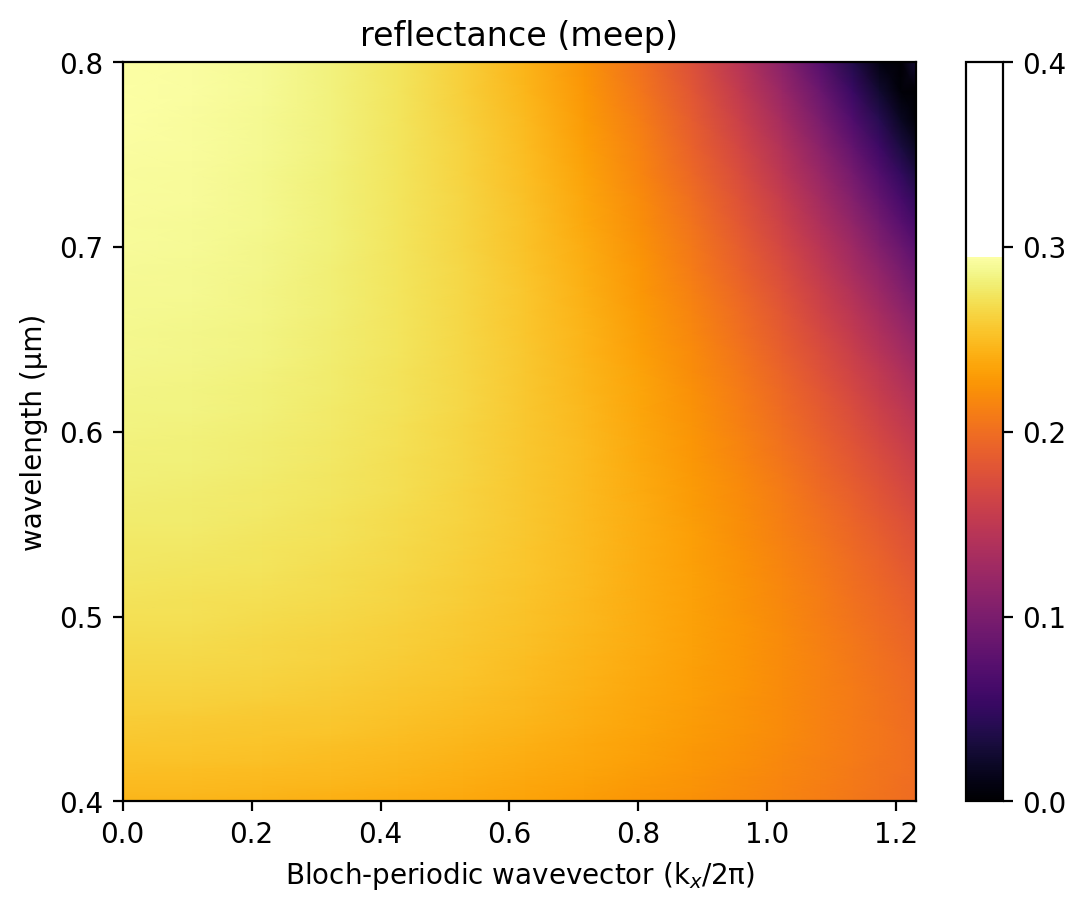

In [3]:
plt.figure(dpi=200)
plt.pcolormesh(
    kxs, wvls, Rmeep, cmap="inferno", shading="gouraud", vmin=0, vmax=Rmeep.max()
)
plt.axis([kxs[0, 0], kxs[0, -1], wvl_min, wvl_max])
plt.yticks([t for t in np.linspace(0.4, 0.8, 5)])
plt.xlabel(r"Bloch-periodic wavevector (k$_x$/2π)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (meep)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0, 0.4, 5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0, 0.4, 5)])

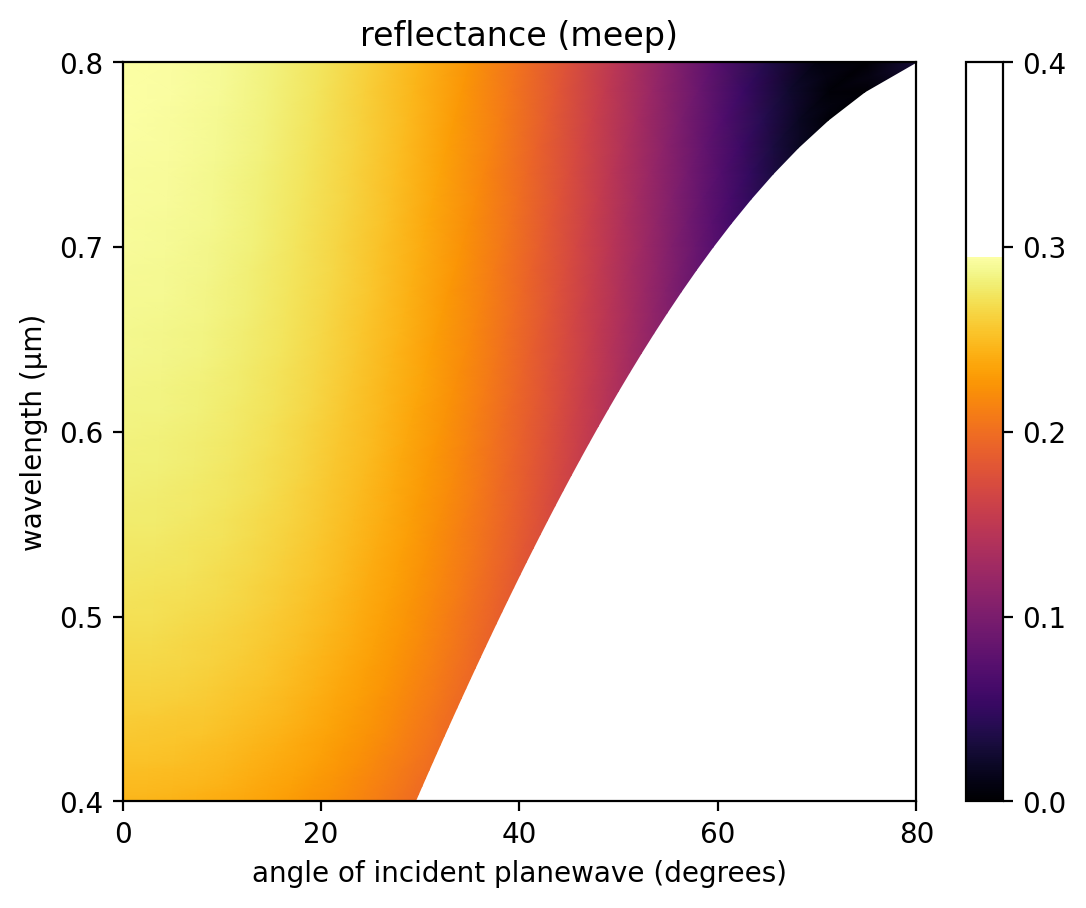

In [4]:
plt.figure(dpi=200)
plt.pcolormesh(
    thetas, wvls, Rmeep, cmap="inferno", shading="gouraud", vmin=0, vmax=Rmeep.max()
)
plt.axis([thetas.min(), thetas.max(), wvl_min, wvl_max])
plt.xticks([t for t in range(0, 100, 20)])
plt.yticks([t for t in np.linspace(0.4, 0.8, 5)])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (meep)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0, 0.4, 5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0, 0.4, 5)])

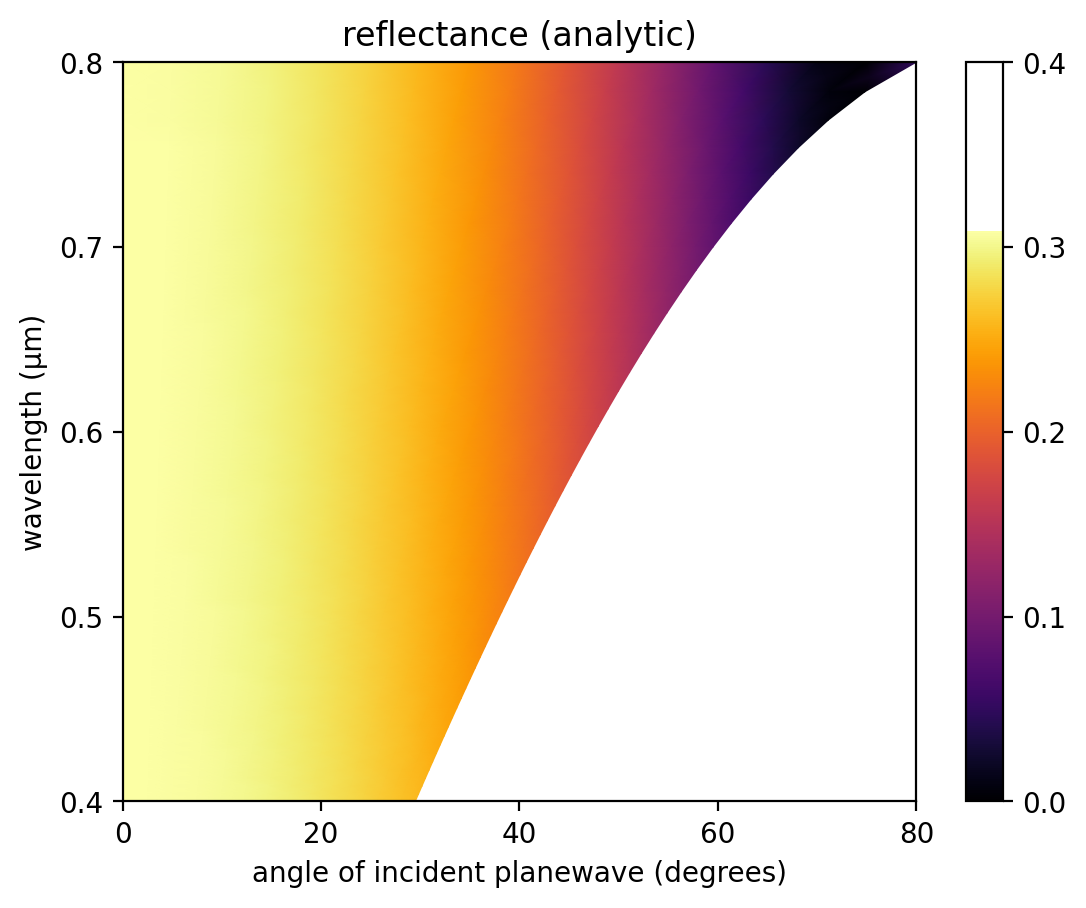

In [5]:
n1 = 1
n2 = 3.5

# compute angle of refracted planewave in medium n2
# for incident planewave in medium n1 at angle theta_in
theta_out = lambda theta_in: math.asin(n1 * math.sin(theta_in) / n2)

# compute Fresnel reflectance for P-polarization in medium n2
# for incident planewave in medium n1 at angle theta_in
Rfresnel = (
    lambda theta_in: math.fabs(
        (n1 * math.cos(theta_out(theta_in)) - n2 * math.cos(theta_in))
        / (n1 * math.cos(theta_out(theta_in)) + n2 * math.cos(theta_in))
    )
    ** 2
)

Ranalytic = np.empty((nfreq, theta_in.size))
for m in range(wvl.size):
    for n in range(theta_in.size):
        Ranalytic[m, n] = Rfresnel(math.radians(thetas[m, n]))

plt.figure(dpi=200)
plt.pcolormesh(
    thetas,
    wvls,
    Ranalytic,
    cmap="inferno",
    shading="gouraud",
    vmin=0,
    vmax=Ranalytic.max(),
)
plt.axis([thetas.min(), thetas.max(), wvl_min, wvl_max])
plt.xticks([t for t in range(0, 100, 20)])
plt.yticks([t for t in np.linspace(0.4, 0.8, 5)])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (analytic)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.linspace(0, 0.4, 5)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0, 0.4, 5)])

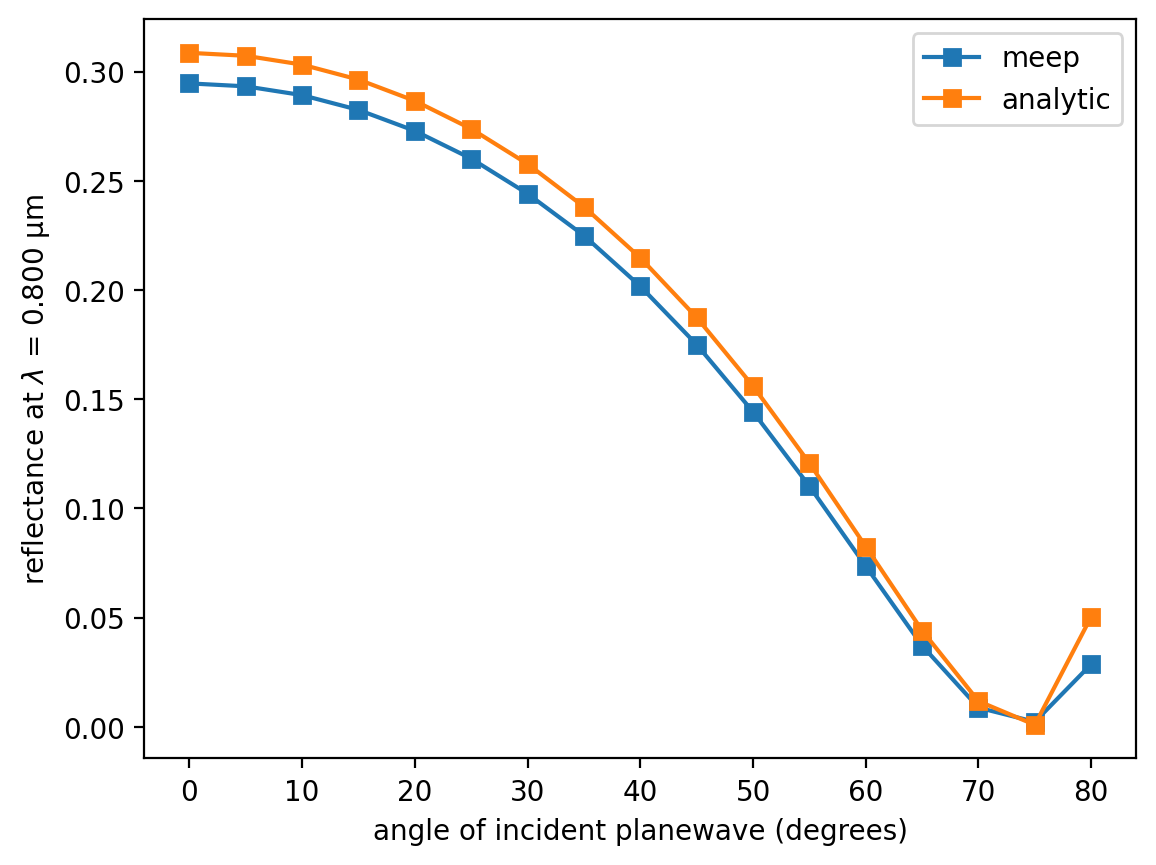

In [6]:
# note: this plots at 0.8 μm, not 0.6 as in the top left image above, in order to correctly show the Brewster angle
wvl_idx = 0
plt.figure(dpi=200)
plt.plot(theta_in,Rmeep[wvl_idx,:],'-s',theta_in,Ranalytic[wvl_idx,:],'-s')
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel(f"reflectance at $\lambda$ = {wvl[wvl_idx]:.3f} μm")
plt.legend(["meep","analytic"])
plt.show()